In [1]:
import sys, os, time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mplimg

In [2]:
# read the measurment data
datetime_arr = np.load("data/datetime_arr.npy", allow_pickle=True)
freq_arr = np.load("data/freq_arr.npy", allow_pickle=True)

n_sweeps_total = int(60 * 24 * 5.5)
n_sweeps_sel = n_sweeps_total

psd_db_arr_per_datetime_lst = []
for sweep_idx in range(n_sweeps_sel):
    # convert to dB
    psd_db_arr = 10*np.log10(np.load("data/psd_arr_%d.npy" %(sweep_idx)))
    psd_db_arr_per_datetime_lst.append(psd_db_arr)
    
psd_db_arr_per_datetime_lst = np.array(psd_db_arr_per_datetime_lst)

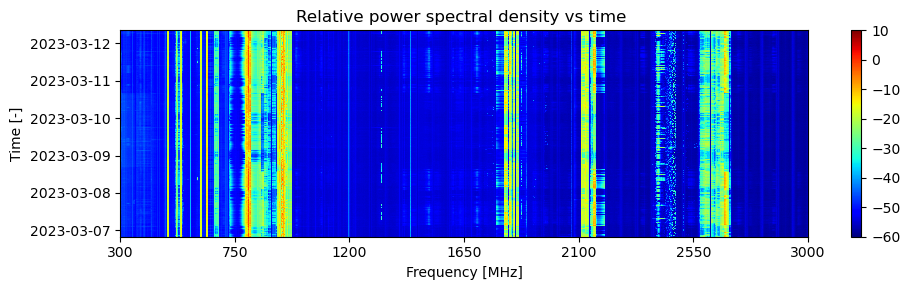

In [3]:
# plot the waterfall PSD
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

im1 = ax.imshow(psd_db_arr_per_datetime_lst, extent=[np.min(freq_arr), np.max(freq_arr), np.min(datetime_arr[:n_sweeps_sel]), np.max(datetime_arr[:n_sweeps_sel])], 
                cmap="jet", vmin=-60, vmax=10, interpolation='None', aspect='auto')
ax.set_title("Relative power spectral density vs time ")
ax.set_xlabel("Frequency [MHz]")
ax.set_ylabel("Time [-]")

x_ticks = np.linspace(np.min(freq_arr), np.max(freq_arr), 19, endpoint=True, dtype=np.int64)
ax.set_xticks(x_ticks, np.round(x_ticks/1e6).astype(int))
y_ticks = [datetime_obj.strftime("%H:%M") for datetime_obj in datetime_arr]
ax.set_yticks(y_ticks)

fig.colorbar(im1, orientation='vertical')

plt.tight_layout()
plt.savefig("figs/timeseries_waterfall_psd_sweep.png", dpi=600, bbox_inches='tight')

plt.show()

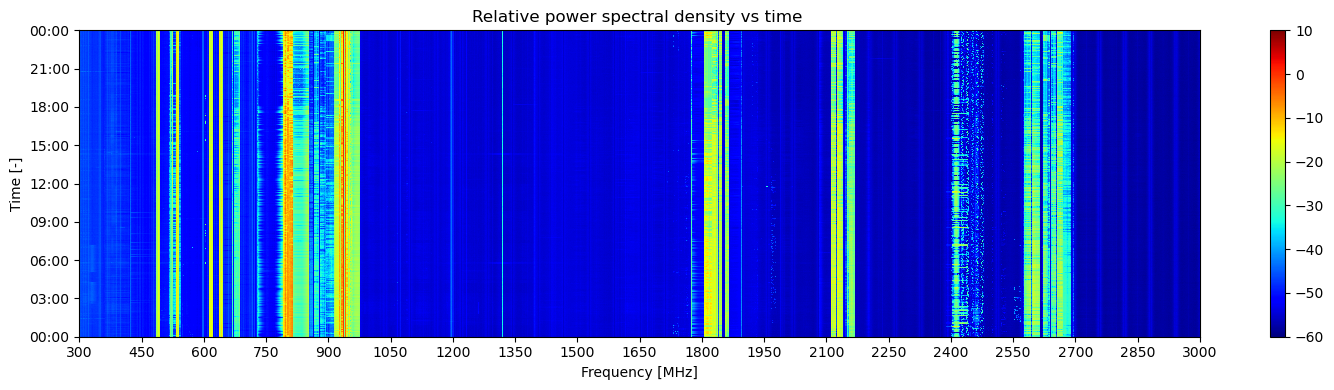

In [3]:
# plot the selected day only
# the measurements took place from 06.03.2023 - 12.03.2023
import datetime

# selected day
starting_date = datetime.datetime(2023, 3, 9)

sel_idx = np.where((datetime_arr >= starting_date) & (datetime_arr < starting_date + datetime.timedelta(days=1)))[0]

# plot the waterfall PSD
fig, ax = plt.subplots(1, 1, figsize=(15, 4))

im1 = ax.imshow(psd_db_arr_per_datetime_lst[sel_idx], extent=[np.min(freq_arr), np.max(freq_arr), np.min(datetime_arr[sel_idx]), np.max(datetime_arr[sel_idx])], 
                cmap="jet", vmin=-60, vmax=10, interpolation='None', aspect='auto')
ax.set_title("Relative power spectral density vs time ")
ax.set_xlabel("Frequency [MHz]")
ax.set_ylabel("Time [-]")

x_ticks = np.linspace(np.min(freq_arr), np.max(freq_arr), 19, endpoint=True, dtype=np.int64)
ax.set_xticks(x_ticks, np.round(x_ticks/1e6).astype(int))

n_y_ticks = 9
dt_interval = (np.max(datetime_arr[sel_idx]) - np.min(datetime_arr[sel_idx])) / (n_y_ticks - 1)
y_ticks = [(np.min(datetime_arr[sel_idx]) + idx*dt_interval) for idx in range(n_y_ticks)]
y_ticks = [(dt.replace(second=0, microsecond=0, minute=0, hour=dt.hour) + datetime.timedelta(hours=dt.minute//30)) for dt in y_ticks]
str_y_ticks = [datetime_obj.strftime("%H:%M") for datetime_obj in y_ticks]
ax.set_yticks(y_ticks, str_y_ticks)

fig.colorbar(im1, orientation='vertical')

plt.tight_layout()
plt.savefig("figs/single_day_waterfall_psd_sweep.png", dpi=600, bbox_inches='tight')

plt.show()

# # save the data as image
# mplimg.imsave('figs/wideband_sweep.png', psd_db_arr_per_datetime_lst, cmap="jet")

In [4]:
# analyze the spectrum occupancy trends 
pwr_threshold_db = -50 + 10 

meas_days_lst = [datetime.datetime(2023, 3, day_idx) for day_idx in range(7, 12)]

spec_occ_per_day = []
t_diff_per_day = []
    
for starting_date in meas_days_lst:
    sel_idx = np.where((datetime_arr >= starting_date) & (datetime_arr < starting_date + datetime.timedelta(days=1)))[0]
    
    spec_occ_vs_time = []
    t_diff_lst = []
    for idx in sel_idx:
        spec_occ = 100 * np.count_nonzero(psd_db_arr_per_datetime_lst[idx] > pwr_threshold_db) / len(psd_db_arr_per_datetime_lst[idx])
        t_diff =  datetime_arr[idx] - starting_date
        spec_occ_vs_time.append(spec_occ)
        t_diff_lst.append(t_diff.seconds)
        
    spec_occ_per_day.append(spec_occ_vs_time)
    t_diff_per_day.append(t_diff_lst)

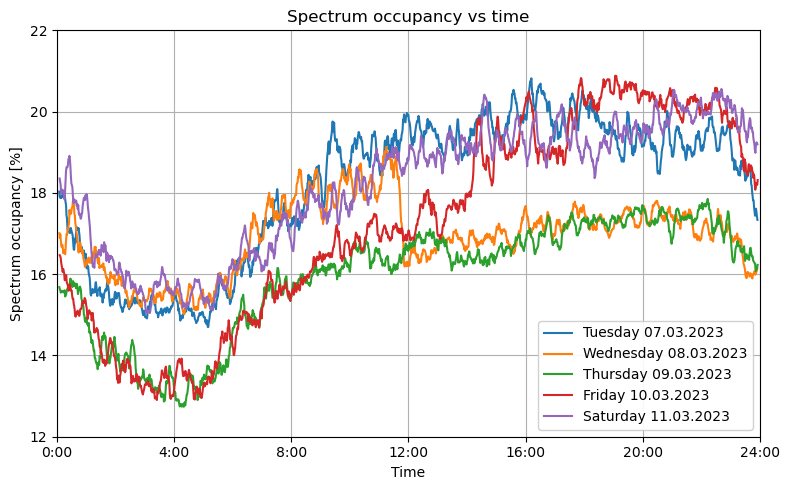

In [5]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

mov_avg_len = 10

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for day_idx, datetime_obj in enumerate(meas_days_lst):
    # apply moving average to denoise the data
    ax.plot(moving_average(t_diff_per_day[day_idx],mov_avg_len), moving_average(spec_occ_per_day[day_idx], mov_avg_len),
            label= datetime_obj.strftime("%A ") + str(datetime_obj.strftime("%d.%m.%Y")))
    
ax.grid()
ax.set_title("Spectrum occupancy vs time")
ax.set_xlabel("Time")
ax.set_ylabel("Spectrum occupancy [%]")
ax.legend(framealpha=0.9, loc='lower right')

x_ticks = np.linspace(0, 24, 7, endpoint=True, dtype=np.int64)
x_ticks_str = ["%d:00" % hour for hour in x_ticks]
ax.set_xticks(x_ticks * 3600, x_ticks_str)

ax.set_xlim([0, 24*3600])
ax.set_ylim([12, 22])

plt.tight_layout()
plt.savefig("figs/spectrum_occupancy_vs_time.png", dpi=600, bbox_inches='tight')

plt.show()